In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import os
from source.data_processing.image_reading import read_image
from source.data_processing.transformations import sample_random_affine_matrix
from typing import Tuple, List
from torchvision import transforms
from kornia.geometry.transform import warp_affine
from matplotlib import pyplot as plt
from source.visualization.image_visualization import plot_images_with_matches
from source.data_processing.keypoints import generate_image_grid_coordinates
from source.data_processing.transformations import *
from source.visualization.image_visualization import plot_image_with_crop
from source.data_processing.cropping import sample_crop_coordinates, crop_image

In [2]:
images_directory = "data/cyto_downscaled_3344_3904/"
image_names = os.listdir(images_directory)
image_1, image_2 = read_image(
    os.path.join(images_directory, image_names[0])
), read_image(os.path.join(images_directory, image_names[1]))
image_1 = transforms.ToTensor()(image_1)
image_2 = transforms.ToTensor()(image_2)
image_size = image_1.shape[-2:]

In [3]:
torch.manual_seed(0)

crop_position_min_x: 318, crop_position_max_x: 2762, crop_position_min_y: 50, crop_position_max_y: 2654
torch.Size([1, 640, 640]) torch.Size([1, 640, 640])


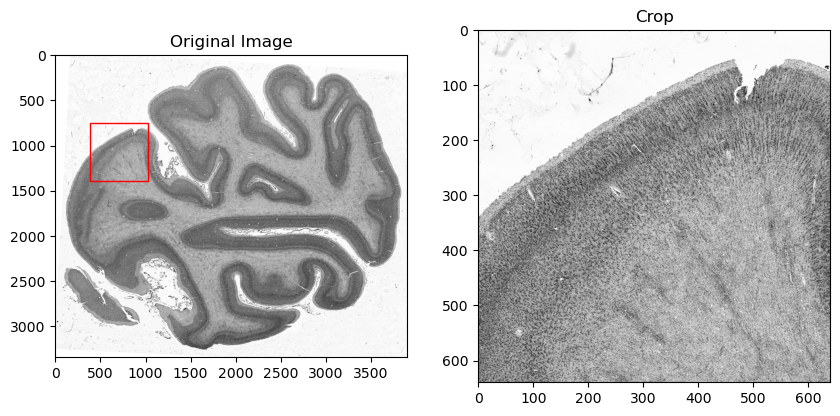

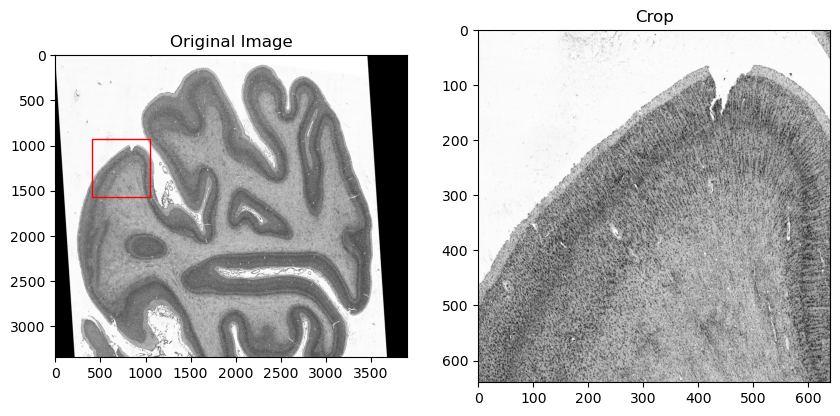

crop_position_min_x: 50, crop_position_max_x: 2024, crop_position_min_y: 93, crop_position_max_y: 2654
torch.Size([1, 640, 640]) torch.Size([1, 640, 640])


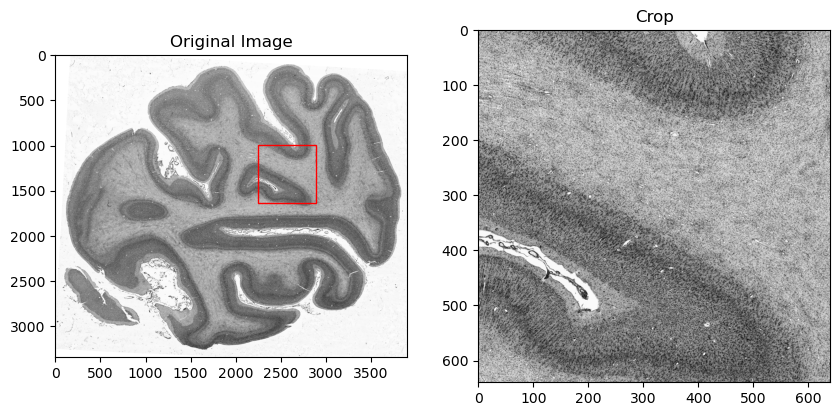

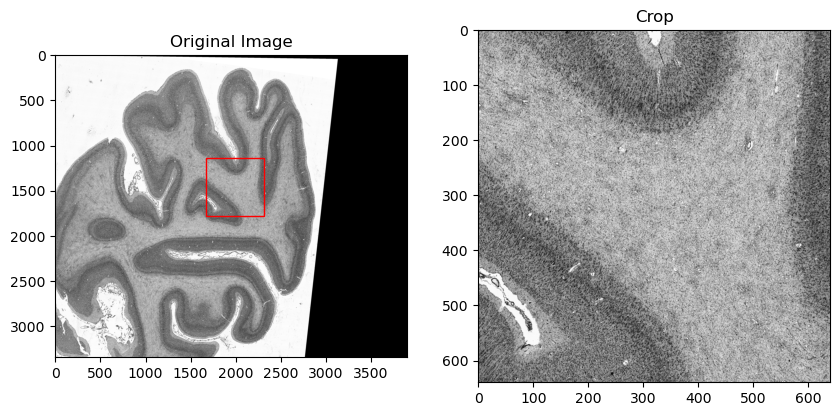

crop_position_min_x: 800, crop_position_max_x: 2972, crop_position_min_y: 50, crop_position_max_y: 2570
torch.Size([1, 640, 640]) torch.Size([1, 640, 640])


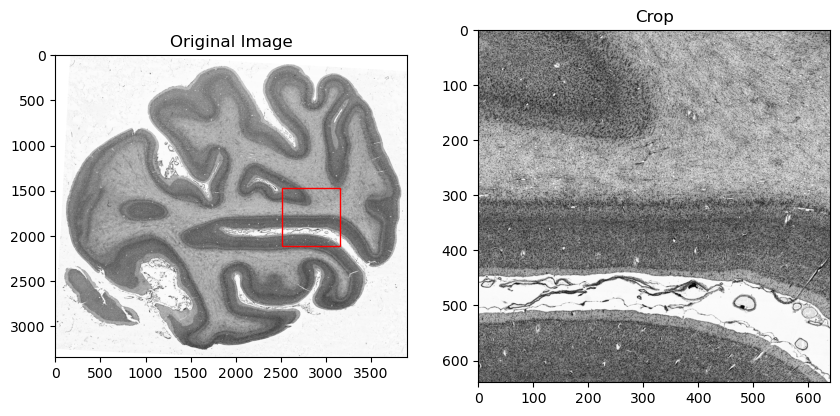

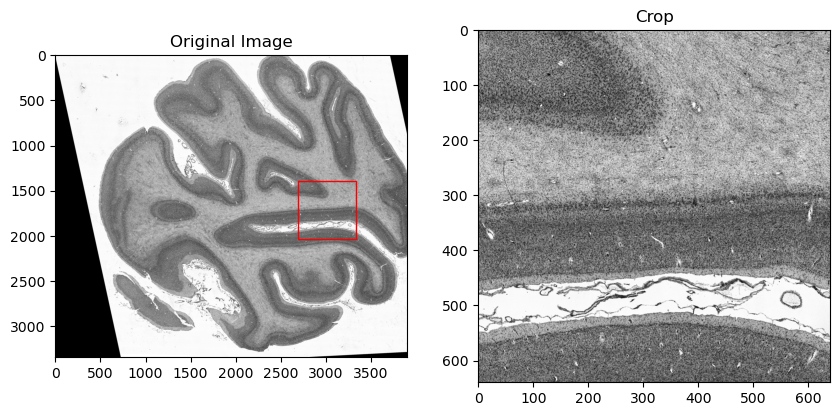

crop_position_min_x: 50, crop_position_max_x: 3214, crop_position_min_y: 50, crop_position_max_y: 1413
torch.Size([1, 640, 640]) torch.Size([1, 640, 640])


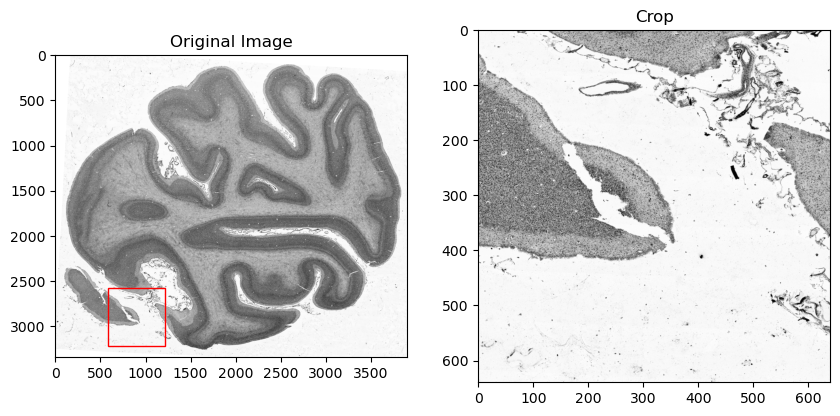

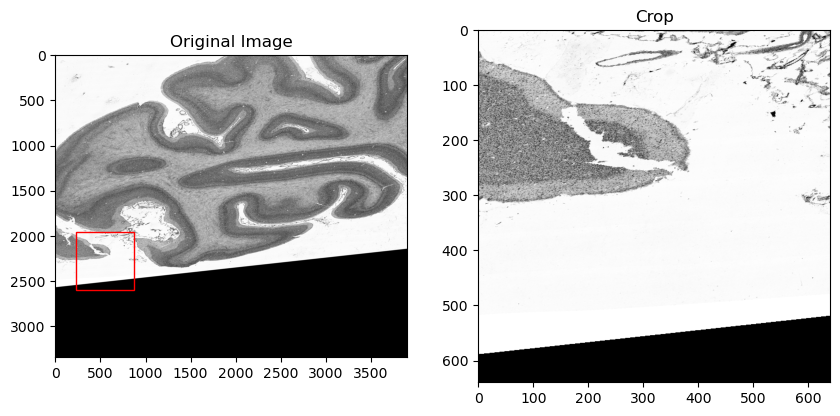

In [5]:
for _ in range(4):
    transformation_matrix = sample_random_affine_matrix(range_limit=0.3)
    image_2_transformed = warp_affine(
        src=image_2.unsqueeze(0), M=transformation_matrix, dsize=image_size, mode="nearest"
    )[0]
    grid_coordinates = generate_image_grid_coordinates(image_size)
    image_coordinate_mapping = transform_grid_coordinates(
        grid_coordinates, transformation_matrix[0]
    )

    crop_size = 640
    max_translation_shift = 50

    crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(
        coordinate_mapping=image_coordinate_mapping,
        crop_size=crop_size,
        max_translation_shift=max_translation_shift,
    )
    

    image_1_crop = crop_image(
        image=image_1, crop_position=crop_position_image_1, crop_size=crop_size
    )
    image_2_crop = crop_image(
        image=image_2_transformed, crop_position=crop_position_image_2, crop_size=crop_size
    )

    print(image_1_crop.shape, image_2_crop.shape)
    plot_image_with_crop(
        original_image=image_1, crop_image=image_1_crop, crop_position=crop_position_image_1
    )
    plot_image_with_crop(
        original_image=image_2_transformed, crop_image=image_2_crop, crop_position=crop_position_image_2
    )

In [45]:
# mask_y = (image_coordinate_mapping[:, :, 1] >= 50) & (image_coordinate_mapping[:, :, 1] <= 1413)
# mask_x = (image_coordinate_mapping[:, :, 0] >= 50) & (image_coordinate_mapping[:, :, 0] <= 3214)
# mask = mask_x & mask_y

In [46]:
# plt.imshow(mask_y)
# plt.imshow(image_2_transformed[0], alpha=0.5)

In [60]:
def get_corners_of_transformed_image(transformed_keypoints_image_shape: torch.tensor) -> tuple:
    """
    Get the corner coordinates of a transformed image.

    Parameters:
    transformed_keypoints_image_shape (torch.tensor): A tensor representing the shape of the transformed image.

    Returns:
    tuple: A tuple containing the coordinates of the top left, top right, bottom left, and bottom right corners of the transformed image.
    """
    top_left = transformed_keypoints_image_shape[0, 0]
    top_right = transformed_keypoints_image_shape[0, -1]
    bottom_left = transformed_keypoints_image_shape[-1, 0]
    bottom_right = transformed_keypoints_image_shape[-1, -1]

    return top_left, top_right, bottom_left, bottom_right

def get_borders_of_crop_sampling(top_left, top_right, bottom_left, bottom_right, image_shape) -> tuple:
    """
    Calculates the borders of the crop sampling area based on the given corner points and image shape. 
    This make sure the crop is not out of bounds, ie. the crop has no black borders.

    Parameters:
    top_left (tuple): The coordinates of the top left corner of the crop area.
    top_right (tuple): The coordinates of the top right corner of the crop area.
    bottom_left (tuple): The coordinates of the bottom left corner of the crop area.
    bottom_right (tuple): The coordinates of the bottom right corner of the crop area.
    image_shape (tuple): The shape of the image (height, width).

    Returns:
    tuple: A tuple containing the minimum and maximum x and y coordinates of the crop sampling area.
    """
    crop_position_min_x = max(top_left[0], bottom_left[0])  # Dont consider image.shape since top_left=[0,0]
    crop_position_max_x = min(top_right[0], bottom_right[0], image_shape[1])
    crop_position_min_y = max(top_left[1], top_right[1])  # Dont consider image.shape since top_left=[0,0]
    crop_position_max_y = min(bottom_right[1], bottom_left[1], image_shape[0])

    return crop_position_min_x, crop_position_max_x, crop_position_min_y, crop_position_max_y

def sample_crop_coordinates(crop_size: int, max_random_offset: int, keypoints: torch.tensor, transformed_keypoints: torch.tensor, transformed_keypoints_image_shape: torch.Tensor, image_shape: torch.Size, ):
    """
    Sample coordinates for both, original and transformed crop.
    :param crop_size: Size of the crop (crop is always square)
    :param max_random_offset: To make sure the first pixel of the original and transformed crop dont match always the transformed crop is shifted by a random offset.
    :param transformed_keypoints: Keypoints of the transformed image of shape (height*width, 2)
    :param transformed_keypoints_image_shape: Keypoints of the transformed image of shape (height, width, 2)
    :param image_shape: Shape of the original image
    
    :return: The starting coordinates (top-left corner) of the original and transformed crop inside the original and transformed image.
    """
    top_left, top_right, bottom_left, bottom_right = get_corners_of_transformed_image(transformed_keypoints_image_shape)
    crop_position_min_x, crop_position_max_x, crop_position_min_y, crop_position_max_y = get_borders_of_crop_sampling(top_left, top_right, bottom_left, bottom_right, image_shape)
    
    # Adjust the conditions to account for the patch size
    mask_x = (transformed_keypoints[:, 0] >= crop_position_min_x + max_random_offset) & (transformed_keypoints[:, 0] <= crop_position_max_x - crop_size - max_random_offset)
    mask_y = (transformed_keypoints[:, 1] >= crop_position_min_y + max_random_offset) & (transformed_keypoints[:, 1] <= crop_position_max_y - crop_size - max_random_offset)

    # Combine the masks
    mask = mask_x & mask_y

    true_indices = torch.nonzero(mask).flatten()
    print(mask.shape, true_indices.shape)

    # Random choice equivalent
    random_index = torch.randint(0, len(true_indices), (1,))
    sampled_index = true_indices[random_index].item()

    # Use sampled_index to index into true_indices
    transformed_sampled_keypoint = transformed_keypoints[sampled_index]
    transformed_sampled_keypoint += torch.randint(-max_random_offset, max_random_offset, (2,), device=transformed_sampled_keypoint.device)  # Add random offset to the transformed chosen keypoint
    sampled_keypoint = keypoints[sampled_index]
    # print(sampled_keypoint==sampled_index)
    # print(sampled_keypoint, sampled_index)

    return sampled_keypoint, transformed_sampled_keypoint

In [64]:
(image_coordinate_mapping.view(-1, 2)[:, 0] >  50).shape

torch.Size([13054976])

In [70]:
((image_coordinate_mapping[:, :, 0] > 50).flatten()==(image_coordinate_mapping.view(-1, 2)[:, 0] >  50)).all()

tensor(True)

torch.Size([13054976]) torch.Size([3908982])
torch.Size([1, 640, 640]) torch.Size([1, 640, 640])


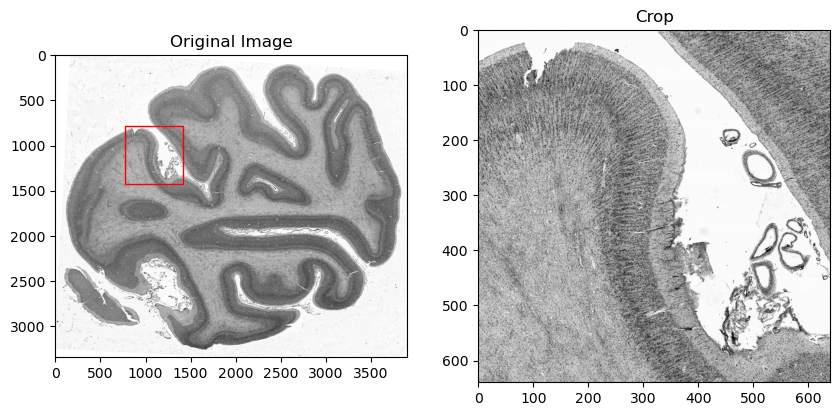

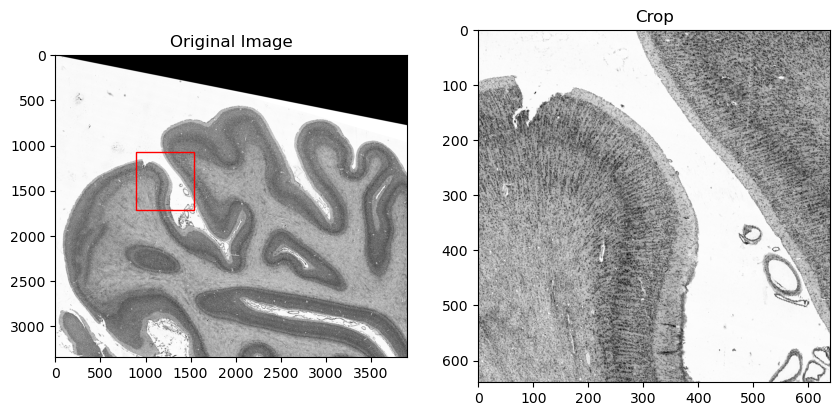

torch.Size([13054976]) torch.Size([3282057])
torch.Size([1, 640, 640]) torch.Size([1, 640, 640])


KeyboardInterrupt: 

In [61]:
for _ in range(10):
    transformation_matrix = sample_random_affine_matrix(range_limit=0.3)
    image_2_transformed = warp_affine(
        src=image_2.unsqueeze(0), M=transformation_matrix, dsize=image_size, mode="nearest"
    )[0]
    grid_coordinates = generate_image_grid_coordinates(image_size)
    image_coordinate_mapping = transform_grid_coordinates(
        grid_coordinates, transformation_matrix[0]
    )

    crop_size = 640
    max_translation_shift = 50

    

    crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(
        crop_size=640,
        max_random_offset=50,
        keypoints=grid_coordinates.view(-1, 2),
        transformed_keypoints=image_coordinate_mapping.view(-1, 2),
        transformed_keypoints_image_shape=image_coordinate_mapping,
        image_shape=image_size,
    )

    
    image_1_crop = crop_image(
    image=image_1, crop_position=crop_position_image_1.long(), crop_size=crop_size
    )
    image_2_crop = crop_image(
    image=image_2_transformed, crop_position=crop_position_image_2.long(), crop_size=crop_size
    )

    print(image_1_crop.shape, image_2_crop.shape)
    plot_image_with_crop(
    original_image=image_1, crop_image=image_1_crop, crop_position=crop_position_image_1
    )
    plot_image_with_crop(
    original_image=image_2_transformed, crop_image=image_2_crop, crop_position=crop_position_image_2
    )

In [39]:


crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(
    crop_size=640,
    max_random_offset=50,
    keypoints=grid_coordinates.view(-1, 2),
    transformed_keypoints=image_coordinate_mapping.view(-1, 2),
    transformed_keypoints_image_shape=image_coordinate_mapping,
    image_shape=image_size,
)

In [43]:
crop_position_image_1

tensor([491., 897.])

torch.Size([1, 640, 640]) torch.Size([1, 640, 640])


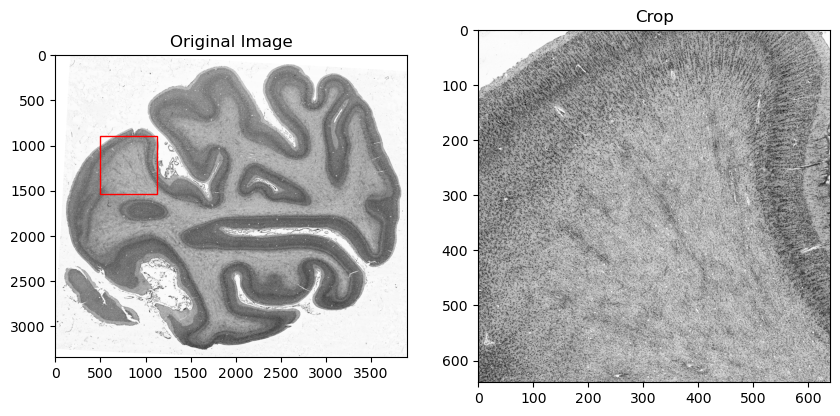

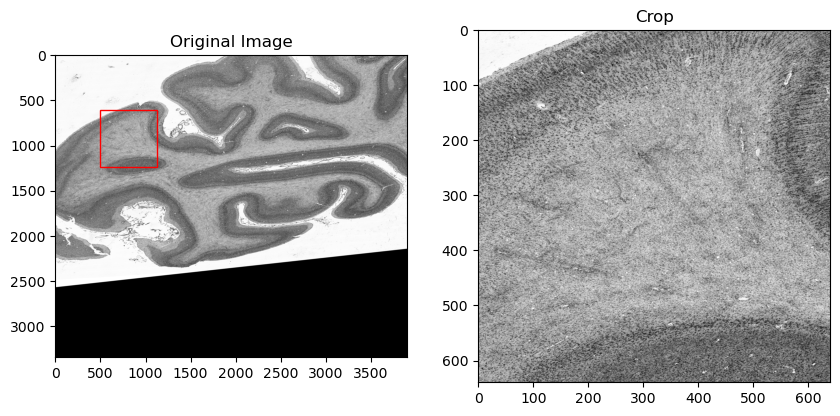

In [44]:
image_1_crop = crop_image(
image=image_1, crop_position=crop_position_image_1.long(), crop_size=crop_size
)
image_2_crop = crop_image(
image=image_2_transformed, crop_position=crop_position_image_2.long(), crop_size=crop_size
)

print(image_1_crop.shape, image_2_crop.shape)
plot_image_with_crop(
original_image=image_1, crop_image=image_1_crop, crop_position=crop_position_image_1
)
plot_image_with_crop(
original_image=image_2_transformed, crop_image=image_2_crop, crop_position=crop_position_image_2
)